In [1]:
import os
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from Genodesic.Utils import load_density_model_from_checkpoint
from Genodesic.Dataloaders.LatentLoader import create_latent_meta_dataloader

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 12
DIM = 24  # Dimension to use from the latent space data

# --- File Paths ---
DATA_FILE = "LatentSpace/trunk-both_dim-24_hvg-2000_latent.pt"
MODEL_DIR = "Models/DensityModels/" 

In [3]:
all_models = {}
model_dir_path = Path(MODEL_DIR)


if not model_dir_path.exists():
    print(f"Directory not found. Cannot load models.")
else:
    for model_file in model_dir_path.glob("*.pt"):
        model_name = model_file.stem  
        try:
            loaded_model = load_density_model_from_checkpoint(
                checkpoint_path=str(model_file),
                device=DEVICE
            )
            all_models[model_name] = loaded_model
        except Exception as e:
            print(f"Failed to load {model_name}. Reason: {e}")

print("\n--- Summary ---")
if all_models:
    print(f"Successfully loaded {len(all_models)} models: {list(all_models.keys())}")
else:
    print("No models were loaded.")

Loading model of type 'rqnsf' from Models/DensityModels/rqnsf_trunk-both_dim-24.pt...
Loading model of type 'vpsde' from Models/DensityModels/vpsde_trunk-both_dim-24.pt...
Loading model of type 'otcfm' from Models/DensityModels/otcfm_trunk-both_dim-24.pt...

--- Summary ---
Successfully loaded 3 models: ['rqnsf_trunk-both_dim-24', 'vpsde_trunk-both_dim-24', 'otcfm_trunk-both_dim-24']


In [ ]:
train_loader, _ = create_latent_meta_dataloader(
    data_file=DATA_FILE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.0
)
test_batch = next(iter(train_loader))[0][:, :DIM].to(DEVICE)
print(f"Test batch loaded successfully. Shape: {test_batch.shape}")

Test batch loaded successfully. Shape: torch.Size([12, 24])


In [ ]:
def compute_score_sensitivity(model, test_batch, perturbations):
    """
    For each perturbation epsilon, compute the L2 norm (Euclidean distance)
    of the per-sample difference ||score(x + eps) - score(x)||.
    """
    baseline = model.compute_score(test_batch)
    sensitivities = []

    for eps in perturbations:
        noise = torch.randn_like(test_batch)
        noise = noise / torch.norm(noise, p=2, dim=1, keepdim=True) * eps
        batch_plus = test_batch + noise
        score_plus = model.compute_score(batch_plus)
        diffs_l2 = torch.norm(score_plus - baseline, p=2, dim=1)
        sensitivities.append(diffs_l2.cpu().detach().numpy())

        del batch_plus, score_plus, diffs_l2
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    sensitivities = np.array(sensitivities)
    mean_sens = np.mean(sensitivities, axis=1)
    return sensitivities, mean_sens

def compute_score_angle(model, test_batch, perturbations):
    """
    For each perturbation epsilon, compute the angle (in radians) between
    score(x) and score(x+eps) for each sample.
    """
    baseline = model.compute_score(test_batch)
    angles = []

    for eps in perturbations:
        noise = torch.randn_like(test_batch)
        noise = noise / torch.norm(noise, p=2, dim=1, keepdim=True) * eps
        batch_plus = test_batch + noise
        score_plus = model.compute_score(batch_plus)

        dot_product = torch.sum(baseline * score_plus, dim=1)
        norm_baseline = torch.norm(baseline, p=2, dim=1)
        norm_score_plus = torch.norm(score_plus, p=2, dim=1)
        
        cos_angle = dot_product / (norm_baseline * norm_score_plus + 1e-8)
        cos_angle = torch.clamp(cos_angle, -1.0, 1.0)
        
        angle = torch.acos(cos_angle)
        angles.append(angle.cpu().detach().numpy())

        del batch_plus, score_plus, cos_angle, angle
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    angles = np.array(angles)
    mean_angles = np.mean(angles, axis=1)
    return angles, mean_angles

In [6]:
# --- Select which models to benchmark for this run ---
# The keys are based on the filenames, e.g., 'vpsde_trunk-both_dim-24'
# Update this list based on the models you loaded.
models_to_benchmark = [key for key in all_models] # Default to all loaded models

# --- Compute metric loop ---
perturbations = np.logspace(-8, -1, 10)
sensitivity_results = {}
angle_results = {}

for name in models_to_benchmark:

    mdl = all_models[name]
    print(f"\nComputing metrics for {name}...")
    start_time = time.time()

    sens, mean_sens = compute_score_sensitivity(mdl, test_batch, perturbations)
    angles, mean_angles = compute_score_angle(mdl, test_batch, perturbations)
    model_time = time.time() - start_time

    sensitivity_results[name] = {
        "perturbations": perturbations, "individual": sens, "mean": mean_sens, "time": model_time
    }
    angle_results[name] = {
        "perturbations": perturbations, "individual": angles, "mean": mean_angles, "time": model_time
    }
    print(f"-> {name} compute time: {model_time:.2f} seconds")


Computing metrics for rqnsf_trunk-both_dim-24...
-> rqnsf_trunk-both_dim-24 compute time: 1.09 seconds

Computing metrics for vpsde_trunk-both_dim-24...
-> vpsde_trunk-both_dim-24 compute time: 0.01 seconds

Computing metrics for otcfm_trunk-both_dim-24...
-> otcfm_trunk-both_dim-24 compute time: 19.58 seconds


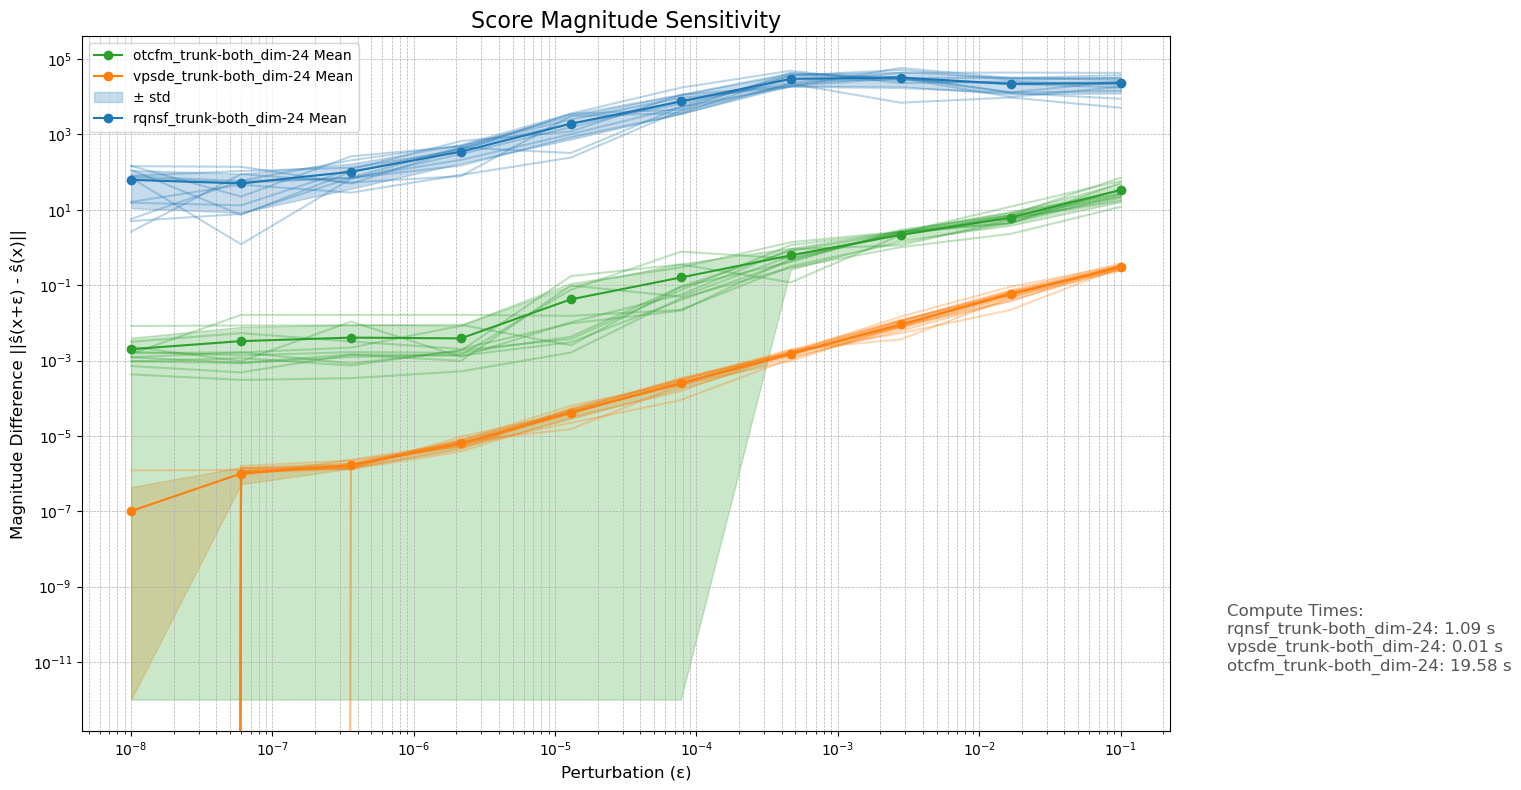

In [7]:
def plot_results(results, title, ylabel, plot_variance=True):
    """A generic plotting function for either sensitivity or angle."""
    plt.style.use('default')
    plt.figure(figsize=(14, 8))
    cmap = plt.get_cmap('tab10')
    n_models = len(results)

    for i, (name, res) in enumerate(results.items()):
        eps, ind, mean_vals = res["perturbations"], res["individual"], res["mean"]
        color = cmap(i)

        for j in range(ind.shape[1]):
            plt.plot(eps, ind[:, j], color=color, alpha=0.3, label='_nolegend_')

        plt.plot(eps, mean_vals, marker='o', linestyle='-', color=color, label=f'{name} Mean')

        if plot_variance:
            std_vals = np.std(ind, axis=1)
            lower_bound = np.maximum(mean_vals - std_vals, 1e-12)
            upper_bound = mean_vals + std_vals
            plt.fill_between(eps, lower_bound, upper_bound, color=color, alpha=0.25,
                             label="± std" if i == 0 else "_nolegend_")

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Perturbation (ε)', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=16)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    lines = [f"{nm}: {rs.get('time', 0):.2f} s" for nm, rs in results.items()]
    if lines:
        text_block = "Compute Times:\n" + "\n".join(lines)
        plt.figtext(0.88, 0.15, text_block, horizontalalignment='left',
                    verticalalignment='bottom', fontsize=12, color='#555555',
                    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

if sensitivity_results:
    plot_results(
        sensitivity_results,
        title='Score Magnitude Sensitivity',
        ylabel='Magnitude Difference ||ŝ(x+ε) - ŝ(x)||'
    )


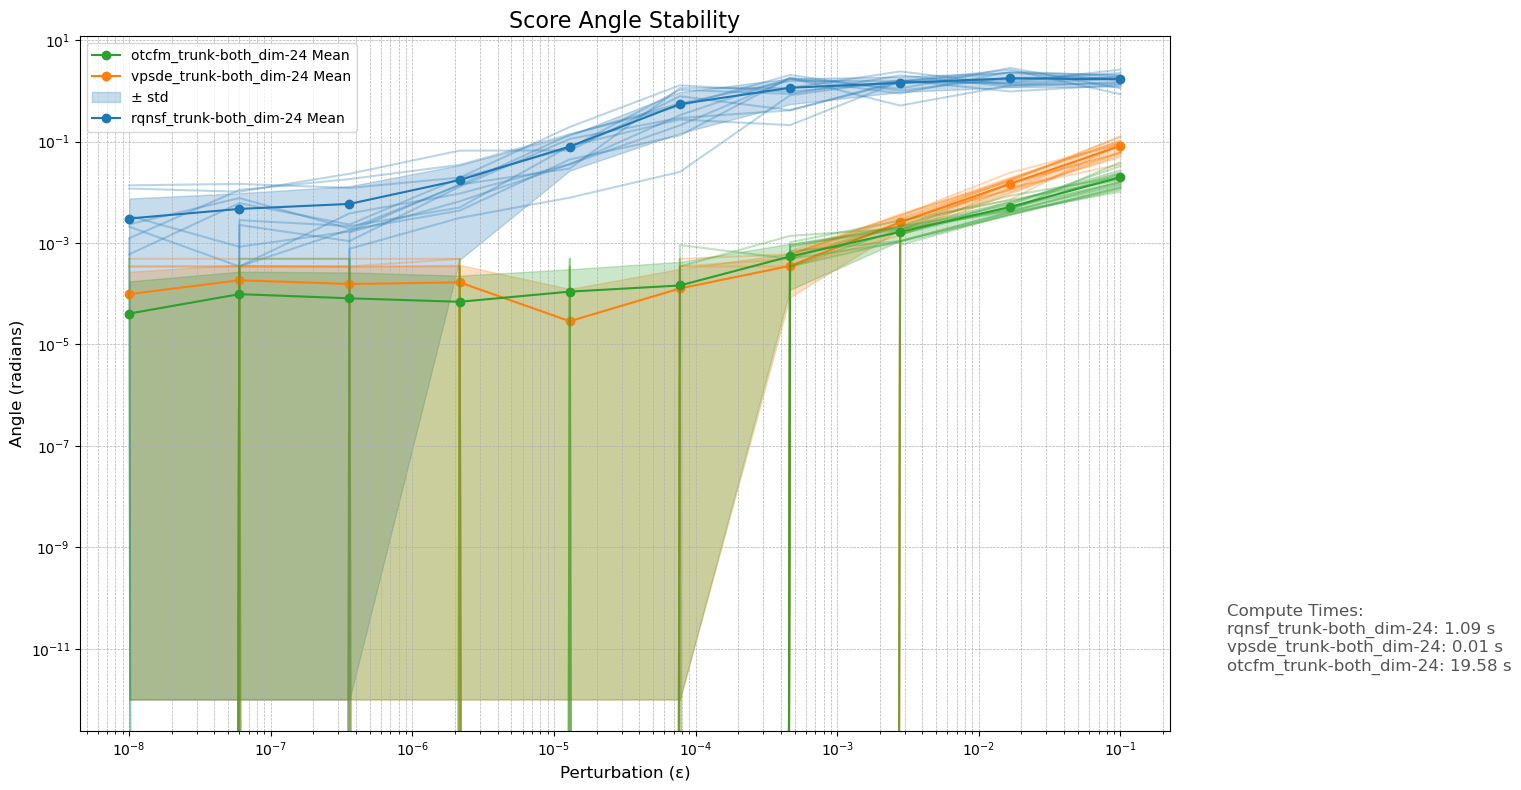

In [ ]:

if angle_results:
    plot_results(
        angle_results,
        title='Score Angle Stability',
        ylabel='Angle (radians)'
    )